# 1. Gender Classification Using Convolutional Neural Network (CNN)

## 1.1 Necessary libraries

In [1]:
import pandas as pd                       # structures and data analysis
import numpy as np
from tensorflow import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import plot_confusion_matrix


## 1.2 Download the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100787 entries, 0 to 100786
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   alternative_names  70745 non-null   object 
 1   classification     100787 non-null  object 
 2   first_name         100787 non-null  object 
 3   frequency_female   60484 non-null   float64
 4   frequency_male     50932 non-null   float64
 5   frequency_total    100787 non-null  int64  
 6   frequency_group    100787 non-null  int64  
 7   group_name         100787 non-null  object 
 8   ratio              100787 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


In [4]:
df.describe()

,frequency_female,frequency_male,frequency_total,frequency_group,ratio
count,6.048400e+04,5.093200e+04,1.007870e+05,1.007870e+05,100787.000000
mean,1.529848e+03,1.740660e+03,1.797718e+03,1.766752e+04,0.981382
std,5.116376e+04,3.856265e+04,4.837138e+04,1.783261e+05,0.076555
min,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,0.500000
25%,3.200000e+01,3.200000e+01,3.300000e+01,8.900000e+01,1.000000
50%,6.300000e+01,6.200000e+01,6.700000e+01,3.520000e+02,1.000000
75%,1.790000e+02,1.770000e+02,1.970000e+02,2.254000e+03,1.000000
max,1.169474e+07,5.732508e+06,1.173413e+07,1.174166e+07,1.000000


### 1.2.1 Preparing the data 

In [5]:
y = df['classification'].astype("category").cat.codes.values # y labels into numbers
names = df['first_name'].apply(lambda x: x.lower()) # input names

## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [6]:
maxlen = 20 # max lenght of a name

vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)

#creating a dictionary
char_index = dict((c, i) for i, c in enumerate(vocab))
char_index

{' ': 11,
 'END': 4,
 'a': 22,
 'b': 5,
 'c': 12,
 'd': 23,
 'e': 10,
 'f': 24,
 'g': 19,
 'h': 7,
 'i': 1,
 'j': 21,
 'k': 3,
 'l': 18,
 'm': 14,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 0,
 'r': 20,
 's': 15,
 't': 13,
 'u': 6,
 'v': 8,
 'w': 9,
 'x': 2,
 'y': 17,
 'z': 16}

In [7]:
#word encoding

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_encod_names(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


x = prepare_encod_names(names.values)

## 1.4 Split the data into test and train

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28) # Segment the data

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

## 1.5 Building the CNN Model

In [9]:
# initilaizing the Sequential nature for CNN model
model = Sequential()  
# 32 convolution filters used each of size 2
model.add(Conv1D(32, 2, activation='relu', input_shape=(20,28) ))
# 64 convolution filters used each of size 3
model.add(Conv1D(64, 3, activation='relu' ))
# choose the best features via pooling
model.add(MaxPooling1D(pool_size=(1,)))
# randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
# flatten we only want a classification output
model.add(Flatten())
# fully connected to get all relevant data
model.add(Dense(150, activation='relu'))
# one more dropout
model.add(Dropout(0.1))
# output 
model.add(Dense(1, activation='sigmoid'))

#opt = keras.optimizers.Adam(learning_rate=0.001)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# print the model
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19, 32)            1824      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 64)            6208      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 17, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1088)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               163350    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0

## 1.6 Fitting the data into model

In [10]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),  epochs=10, batch_size=128) # Getting score metrics
scores = model.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
630/630 [==============================] - 12s 18ms/step - loss: 0.6350 - accuracy: 0.6222 - val_loss: 0.3270 - val_accuracy: 0.8533
Epoch 2/10
630/630 [==============================] - 11s 17ms/step - loss: 0.3261 - accuracy: 0.8526 - val_loss: 0.2730 - val_accuracy: 0.8819
Epoch 3/10
630/630 [==============================] - 11s 17ms/step - loss: 0.2818 - accuracy: 0.8756 - val_loss: 0.2511 - val_accuracy: 0.8912
Epoch 4/10
630/630 [==============================] - 11s 18ms/step - loss: 0.2589 - accuracy: 0.8892 - val_loss: 0.2360 - val_accuracy: 0.9012
Epoch 5/10
630/630 [==============================] - 11s 17ms/step - loss: 0.2441 - accuracy: 0.8963 - val_loss: 0.2272 - val_accuracy: 0.9054
Epoch 6/10
630/630 [==============================] - 11s 17ms/step - loss: 0.2297 - accuracy: 0.9056 - val_loss: 0.2195 - val_accuracy: 0.9105
Epoch 7/10
630/630 [==============================] - 10s 17ms/step - loss: 0.2266 - accuracy: 0.9064 - val_loss: 0.2129 - val_accuracy:

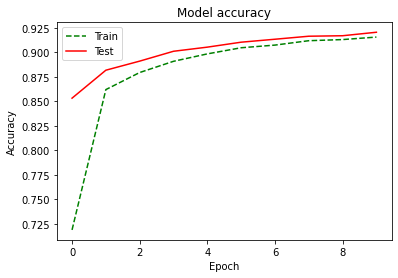

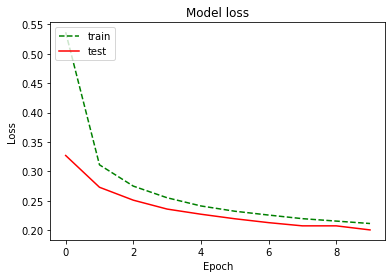

In [11]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'], 'g--')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], 'g--')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

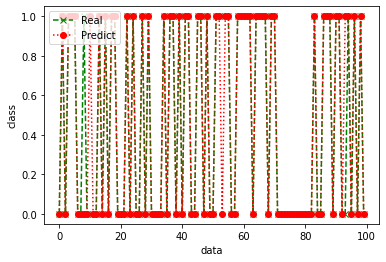

In [12]:
y_pred =(model.predict(x_test) > 0.5).astype("int32")
plt.figure(2)
plt.plot(y_test[0:100], 'g--x')
plt.plot(y_pred[0:100], 'r:o')
plt.ylabel('class')
plt.xlabel('data')
plt.legend(['Real', 'Predict'], loc='upper left')
plt.show()